In [1]:
from matplotlib.pylab import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from collections import defaultdict
import time

1. Считать цветное rgb изображение

In [2]:
def plt_show_img(img, is_gray = False):
    axis("off")
    imshow(img, cmap = plt.get_cmap('gray') if is_gray else None)

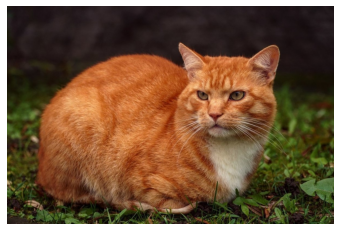

In [3]:
IMG_PATH = "./kitty4.jpg"

img = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)
plt_show_img(img, False)

In [4]:
img.shape

(800, 1200, 3)

2. Зашумить изображение аддитивным шумом с вероятностью p=0,1

In [5]:
def img_gaussian_noise(rgb_img, p=0.1, noise_mean=90, noise_std=80, seed=54378643684727644864326634562):
    result = rgb_img.copy()
    rng = np.random.default_rng(seed)
    m, n, k = result.shape
    gaussian = np.zeros((m*n, k), dtype=uint8)
    r_x = rng.choice(m*n, int(m*n*p))
    gaussian[r_x] = np.random.normal(noise_mean, noise_std, int(m*n*p)*k).reshape(int(m*n*p), k)
    result = cv2.add(result, gaussian.reshape((m, n, k)))
    return result

In [6]:
img_noisy = img_gaussian_noise(img, seed=time.time_ns())

In [7]:
%matplotlib inline

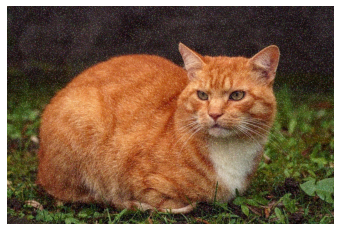

In [8]:
plt_show_img(img_noisy)

3. Написать функцию реализации ранговой фильтрации вида fun(Image, window, rank), где window - окно фильтрации (по вариантам), rank - опциональный параметр, значение ранга в ранговой фильтрации

In [16]:
def img_rank_filter(_img, window=np.array([[1,1,1],[1,3,1],[1,1,1]]), rank=0):
    win_x, win_y = window.shape
    img_x, img_y, img_z = img.shape
    pad_x, pad_y = window.shape[0] // 2, window.shape[1] // 2
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(
        np.pad(_img, [(pad_x, pad_x),(pad_y, pad_y),(0,0)], mode='constant'), (win_x, win_y, 3)
    )
    fil_x, fil_y, fil_z, win_x, win_y, img_z = img_sliding_window.shape
    flat_win = window.flatten()
    img_sliding_window = np.repeat(img_sliding_window.reshape((fil_x*fil_y*fil_z, win_x*win_y, img_z)), flat_win, axis=1)
    img_sliding_window = np.sort(np.swapaxes(img_sliding_window, 1, 2), axis=2)[:, :, rank]
    return img_sliding_window.reshape(_img.shape)

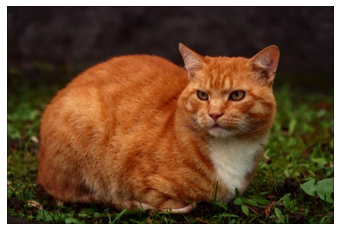

In [17]:
img_filtered = img_rank_filter(img_noisy)
plt_show_img(img_filtered)

4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам). Подсчитать СКО для результата фильтрации с каждым рангом:

    - __Вход__: изображение из пункта 2.
    - __Выход__: значения СКО для каждого ранга. Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованные изображения для первого, последнего ранга, а так же для ранга с наименьшим СКО.
    - СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

In [11]:
img_filtered_first = img_rank_filter(img_noisy, rank=0)
img_filtered_last = img_rank_filter(img_noisy, rank=10)
img_filtered_best = img_filtered_first
filtered_best_rank = 0
filtered_std = np.std(img - img_filtered_first)
for i in range(11):
    filtered = img_rank_filter(img_noisy, rank=i)
    new_std = np.std(img - filtered)
    print('Rank: ' + str(i) + ', std: ' + str(new_std))
    if new_std < filtered_std:
        filtered_best_rank = i
        filtered_std = new_std
        img_filtered_best = filtered
print('Best results with rank', filtered_best_rank)

Rank: 0, std: 17.72386845026261
Rank: 1, std: 24.57921211872512
Rank: 2, std: 33.055013765046404
Rank: 3, std: 58.95839937430929
Rank: 4, std: 84.57135471934349
Rank: 5, std: 104.82104061386592
Rank: 6, std: 120.2007416138001
Rank: 7, std: 121.80470825594011
Rank: 8, std: 109.78407755182786
Rank: 9, std: 93.12214850540124
Rank: 10, std: 81.70734378126122
Best results with rank 0


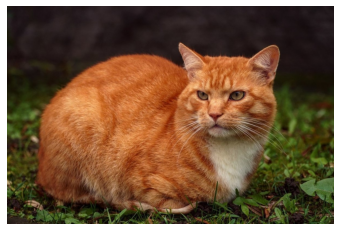

In [35]:
plt_show_img(img)

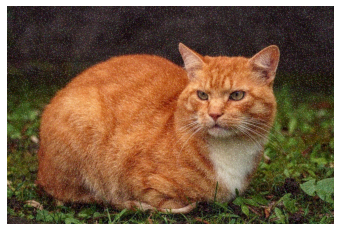

In [36]:
plt_show_img(img_noisy)

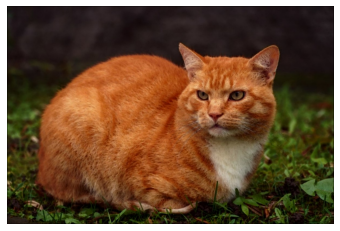

In [37]:
plt_show_img(img_filtered_first)

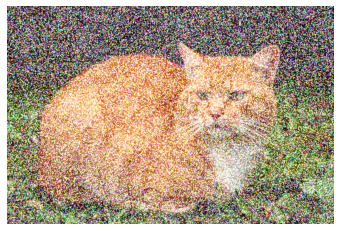

In [38]:
plt_show_img(img_filtered_last)

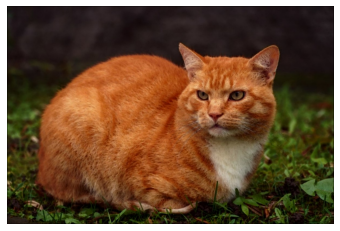

In [39]:
plt_show_img(img_filtered_best)

5. Написать функцию реализации свертки вида fun(mat1, mat2), где mat1 - первый сигнал (изображение), mat2 - второй сигнал (ядро КИХ фильтра).

In [18]:
def img_fir_filter(img, filter_kernel=np.array([[2,1,2],[1,1,1],[2,1,2]])*(1/13)):
    win_x, win_y = filter_kernel.shape
    img_x, img_y, img_z = img.shape
    pad_x, pad_y = filter_kernel.shape[0] // 2, filter_kernel.shape[1] // 2
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(
        np.pad(img, [(pad_x, pad_x),(pad_y, pad_y),(0,0)], mode='constant'), (win_x, win_y, 3)
    )
    fil_x, fil_y, fil_z, win_x, win_y, img_z = img_sliding_window.shape
    img_sliding_window = img_sliding_window.reshape((fil_x*fil_y*fil_z, win_x*win_y, img_z))
    flat_rev_kernel = np.flip(filter_kernel.flatten()).reshape((9,1))
    #img_sliding_window = img_sliding_window
    return (img_sliding_window[:]*flat_rev_kernel).sum(axis=1).astype(uint8).reshape(img.shape)

6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.

    - __Вход__: изображение из пункта 2.
    - __Выход__: значения СКО . Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение.
    - СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

Orig std: 55.294080023951295


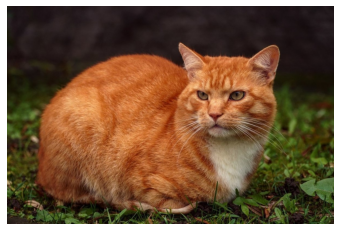

In [13]:
new_std = np.std(img)
print('Orig std: ' + str(new_std))
plt_show_img(img)

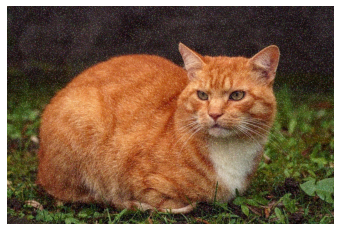

In [14]:
plt_show_img(img_noisy)

FIR filtered std: 55.17235187841043


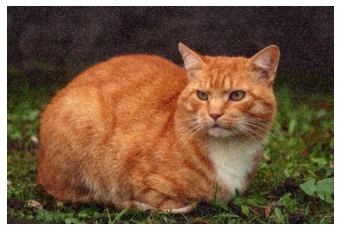

In [19]:
kernel=np.array([[1,7,1],[7,11,7],[1,7,1]])*(1/43)
filtered = img_fir_filter(img_noisy, filter_kernel=kernel)
new_std = np.std(filtered)
print('FIR filtered std: ' + str(new_std))
plt_show_img(filtered)

По результатам выполнения лабораторной работы выяснилось, что лучшее качество даёт фильтрация изображения ранговым фильтром с маской [[1,1,1],[1,3,1],[1,1,1]] и рангом 0.